In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import optimizers


In [2]:
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 100

In [3]:
bucket = 'leaseplan-oct-2019-ml-immersion'
prefix = 'lease-plan'
filename = 'sample_data.csv'
s3_fullpath = os.path.join('s3://', bucket, prefix, 'raw-data', filename)

!aws s3 cp $s3_fullpath .

download: s3://leaseplan-oct-2019-ml-immersion/lease-plan/raw-data/sample_data.csv to ./sample_data.csv


In [4]:
# Read from S3 or local
raw_data = pd.read_csv(filename, header=0, sep=',')


########################
# Drop list of iobjectid that has corrupted data
########################
iobjectid = [161541]
raw_data = raw_data[~raw_data['iobjectid'].isin(iobjectid)]
raw_data.reset_index(inplace=True)
print(raw_data.shape)

(62, 30)


In [5]:
raw_data.head()

,index,iobjectid,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,customertopnode,make,model,vehicledesc,bodytype,serviceorderid,accountingindicator,serviceinterval,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder
0,0,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER - SUMP PLUG,1 ST,0.000,1.320,0.000,1.320,130.910
1,1,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER ADDITIVE,1 ST,0.000,0.000,0.000,0.000,130.910
2,2,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WORKSHOP SUPPLIES,1 ST,0.000,8.010,0.000,8.010,130.910
3,3,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1 ST,0.800,0.000,66.000,66.000,130.910
4,4,161531,26JUL2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801369140,Budget,80000.000,80328,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,DIFF OIL,1 L,0.000,26.100,0.000,26.100,405.410


## Helper functions

In [6]:
import os
import io
import boto3



def get_col_with_null(df):
    series = raw_data.isnull().sum()
    null_col = series[series != 0].index
    
    return list(null_col)


def data_transformation(df):
    
    raw_data = df.copy()
    print(f'Initial data shape: {raw_data.shape}')
    

    # replace null col with 0
    col_with_null = get_col_with_null(raw_data)
    raw_data[col_with_null] = raw_data[col_with_null].fillna(0) 
    
    num_features = raw_data.select_dtypes(exclude='object').columns
    cat_features = raw_data.select_dtypes(include='object').columns

    assert(len(cat_features)+len(num_features) == len(raw_data.columns))
    
    # Column to be dropped
    drop_columns = ['serviceorderid', # grouping info has been implicited used during feature engineering
                    'iobjectid', # does not tell much info, drop for now
                    'customertopnode', # highly corrected to iobjectid
                    'serviceinterval', # highly Correlated to serviceorderid 
                    'terminationflag', #single value: "#"
                     'terminationtype', #single value: "not assigned"
                     'vehicledesc', # text is ignored for now, embedding can be done
                     'accountingindicator', #single value: "budget"
                    ]
    
    
    ########################
    # Feature engineering
    ########################
    # Take 1st 2-digits of post code
    raw_data['supplierpostcode'] = raw_data['supplierpostcode'].apply(lambda x: int(x / 100))
        
    # Check that by grouping 'serviceorderid', the total cost is equal to 'totalcostbyserviceorder'
    raw_data_gb = raw_data.groupby('serviceorderid')['costexcgst']

    total_cost_df = pd.DataFrame(raw_data_gb.sum())
    total_cost_df.columns = ['totalcost_check']

    raw_data = raw_data.merge(total_cost_df, on='serviceorderid')
    raw_data['unmatched_total'] = np.where((raw_data['totalcostbyserviceorder'] - raw_data['totalcost_check']).astype(int) != 0, 1, 0)
    raw_data['cost_ratio'] = raw_data['costexcgst'] / raw_data['totalcostbyserviceorder']

    # Extract numerical quantity without unit
    raw_data['quantity'] = raw_data['quantity'].str.extract('(\d+)')
    raw_data['quantity'] = raw_data['quantity'].fillna(1)

    # treat these as categorical instead of numerical, 
    num_to_cat_col = ['supplierpostcode','industry_code']
    cat_to_num_col = ['quantity']
    

    # update date column to datetime types
    raw_data['jobdate'] = pd.to_datetime(raw_data['jobdate'])
    raw_data['contractstartdateorig'] = pd.to_datetime(raw_data['contractstartdateorig'])
    raw_data['contractenddate'] = pd.to_datetime(raw_data['contractenddate'])
    raw_data['lastknownododate'] = pd.to_datetime(raw_data['lastknownododate'])
    raw_data['builddate'] = pd.to_datetime(raw_data['builddate'])

    date_col = list(raw_data.select_dtypes('datetime64').columns)
    print(f'Date col: {date_col}\n')
    
    # Contract duration
    duration_day = raw_data['contractenddate'] - raw_data['contractstartdateorig']
    raw_data['contract_duration_days'] = duration_day.map(lambda x: x.days)   
    
    # Car ages
    car_age_days = pd.datetime.now() - raw_data['builddate']
    raw_data['car_age_days'] = car_age_days.map(lambda x: x.days)


    ########################
    # New feature to be added
    ########################
    new_num_col = ['contract_duration_days','car_age_days','cost_ratio']
    new_cat_col = ['unmatched_total']
    
    
    ########################
    # Columnn name tracking
    ########################
    final_num_features = list(set(num_features) - set(num_to_cat_col) - set(drop_columns))
    final_num_features = final_num_features + new_num_col + cat_to_num_col
    print(f'Num features: {final_num_features}\n')

    final_cat_features = list(set(cat_features) - set(date_col) - set(cat_to_num_col) - set(drop_columns))
    final_cat_features = final_cat_features + new_cat_col + num_to_cat_col
    print(f'Catogorial features: {final_cat_features}\n')

    raw_data[final_cat_features] = raw_data[final_cat_features].apply(lambda x: x.astype('category'))
    raw_data[final_num_features] = raw_data[final_num_features].apply(lambda x: x.astype('float'))

    data = raw_data[final_num_features+final_cat_features]
    
    ########################
    # Onehot for categorical column
    ########################
    data = pd.get_dummies(data, prefix_sep='_', drop_first=True)
    data = data.astype('float')

    
    ########################
    # Standardization
    ########################
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    pca = PCA(n_components=2)
    pca_df = pd.DataFrame(pca.fit_transform(data_scaled), columns=['pca1','pca2'])  
    data_scaled = pd.concat([data_scaled, pca_df], axis=1)

    print(f'New data shape: {data_scaled.shape}')


    return data_scaled


def plot_anomaly(df):
    """Plot pca1/pca2 column with anomaly colormap"""
    
    temp = df.sort_values(['anomaly'], ascending=True)

    fig, ax = plt.subplots(figsize=(10,5))

    cm = {0:'green', 1:'red'}
    ax.scatter(x=temp['pca1'], y=temp['pca2'], c=temp['anomaly'].apply(lambda x: cm[x]))
    plt.show()

def save_s3_file_csv(bucket, file_data, dataset, header=None, index=None):
    csv_buffer = io.StringIO()
    dataset.to_csv(csv_buffer, header=header, index=index)
    s3_client = boto3.client('s3')
    response = s3_client.put_object(Bucket=bucket, Key=file_data, Body=csv_buffer.getvalue())
    return response


def plot_dl_loss(model, loss=False):
    
    history = model.history.history
    
    plt.plot(history['loss'])
    
    if(loss):
        plt.plot(history['val_loss'])
        plt.legend(['train', 'test'], loc='upper right');

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')


## Data Transformation


In [7]:
new_data = data_transformation(raw_data)
new_data.head()

Initial data shape: (62, 30)
Date col: ['jobdate', 'contractstartdateorig', 'contractenddate', 'lastknownododate', 'builddate']

Num features: ['labourcost', 'index', 'odometer', 'partscost', 'supplier_srt', 'totalcostbyserviceorder', 'costexcgst', 'contract_duration_days', 'car_age_days', 'cost_ratio', 'quantity']

Catogorial features: ['industry_desc', 'model', 'productshorttext', 'contractserviceitem', 'servicetype', 'bodytype', 'make', 'unmatched_total', 'supplierpostcode', 'industry_code']

New data shape: (62, 46)


,labourcost,index,odometer,partscost,supplier_srt,totalcostbyserviceorder,costexcgst,contract_duration_days,car_age_days,cost_ratio,quantity,industry_desc_Services: Social Services,industry_desc_Transport and Communications: Electricit,model_Hiace,model_Hilux,productshorttext_DIFF OIL,productshorttext_ENGINE OIL,productshorttext_ENVIRONMENTAL LEVY,productshorttext_FUEL FILTER,productshorttext_GEAR OIL,productshorttext_GLOBE - BRAKE LIGHT RIGHT,productshorttext_OIL FILTER,productshorttext_SCH_SRV_TOYOTA_061,productshorttext_SERVICE BRAKE FLUID,productshorttext_SPARK PLUGS,productshorttext_TOYOTA ADVANTAGE SERVICE,productshorttext_TRAILER PLUG,productshorttext_VEHICLE INSPECTION,productshorttext_WASHER - SUMP PLUG,productshorttext_WASHER ADDITIVE,productshorttext_WHEEL ALIGNMENT - TOE,productshorttext_WHEEL BALANCE X 2,productshorttext_WORKSHOP SUPPLIES,contractserviceitem_Misc Operating Costs Budget,contractserviceitem_Service Plan,servicetype_Wear & Tear,bodytype_Station Wagon,bodytype_Van,make_Toyota,unmatched_total_1,supplierpostcode_30,supplierpostcode_45,industry_code_4049.0,industry_code_8083.0,pca1,pca2
0,0.000,0.000,0.390,0.009,0.000,0.289,0.009,0.000,0.000,0.010,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,-0.237,0.165
1,0.000,0.010,0.390,0.000,0.000,0.289,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,-0.245,0.165
2,0.000,0.020,0.390,0.056,0.000,0.289,0.056,0.000,0.000,0.061,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,-0.203,0.177
3,0.500,0.030,0.390,0.000,0.500,0.289,0.462,0.000,0.000,0.504,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,1.442,-0.160
4,0.000,0.040,0.514,0.183,0.000,1.000,0.183,0.000,0.000,0.064,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,-0.190,-0.152


## Algorithm - Autoencoder

In [8]:
# test_ratio = 0.1
# test_X = new_data.sample(frac=test_ratio).iloc[:, :-2]
# train_X = new_data.iloc[list(set(new_data.index)-set(test_X.index))].iloc[:, :-2]
# print('Train:',train_X.shape, 'Test:',test_X.shape)

train_df = new_data.iloc[:,:-2]
feature_dim = train_df.shape[1]
enc_dim = 5

print(f'feature_dim: {feature_dim}, enc_din: {enc_dim}')


feature_dim: 44, enc_din: 5


In [9]:
def fit_model(train_df):

    model = Sequential()

    # Encoder
    model.add(Dense(enc_dim, activation='relu', input_shape=(feature_dim,)))

    # Decoder
    model.add(Dense(feature_dim, activation='relu'))

    sgd = optimizers.SGD(lr=0.01)

    model.compile(optimizer=sgd,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    model.fit(train_df, train_df, 
              epochs=100, 
              batch_size=100, 
              #validation_data=(test_X,test_X),
              verbose=1,
             )

    predictions = model.predict(train_df, verbose=0)
    mse = np.mean(np.power(train_df - predictions, 2), axis=1)
    print(f'mse: {mse.sum()}')
    
    return mse
    
############
# Train
mse = fit_model(train_df)

W1016 12:42:26.028798 139955842344768 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1016 12:42:26.051559 139955842344768 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1016 12:42:26.054036 139955842344768 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1016 12:42:26.093731 139955842344768 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.t

Epoch 1/100
62/62 [==============================] - 1s 9ms/step - loss: 1.9746 - acc: 0.7368
Epoch 2/100
62/62 [==============================] - 0s 50us/step - loss: 1.8973 - acc: 0.7372
Epoch 3/100
62/62 [==============================] - 0s 38us/step - loss: 1.8713 - acc: 0.7379
Epoch 4/100
62/62 [==============================] - 0s 39us/step - loss: 1.8366 - acc: 0.7383
Epoch 5/100
62/62 [==============================] - 0s 37us/step - loss: 1.8241 - acc: 0.7386
Epoch 6/100
62/62 [==============================] - 0s 39us/step - loss: 1.7936 - acc: 0.7394
Epoch 7/100
62/62 [==============================] - 0s 37us/step - loss: 1.7695 - acc: 0.7394
Epoch 8/100
62/62 [==============================] - 0s 37us/step - loss: 1.7469 - acc: 0.7394
Epoch 9/100
62/62 [==============================] - 0s 36us/step - loss: 1.7351 - acc: 0.7405
Epoch 10/100
62/62 [==============================] - 0s 39us/step - loss: 1.7269 - acc: 0.7419
Epoch 11/100
62/62 [==============================

Epoch 87/100
62/62 [==============================] - 0s 34us/step - loss: 1.3145 - acc: 0.7625
Epoch 88/100
62/62 [==============================] - 0s 39us/step - loss: 1.3136 - acc: 0.7628
Epoch 89/100
62/62 [==============================] - 0s 39us/step - loss: 1.3128 - acc: 0.7632
Epoch 90/100
62/62 [==============================] - 0s 39us/step - loss: 1.3119 - acc: 0.7636
Epoch 91/100
62/62 [==============================] - 0s 39us/step - loss: 1.3111 - acc: 0.7643
Epoch 92/100
62/62 [==============================] - 0s 57us/step - loss: 1.3103 - acc: 0.7647
Epoch 93/100
62/62 [==============================] - 0s 30us/step - loss: 1.3095 - acc: 0.7650
Epoch 94/100
62/62 [==============================] - 0s 30us/step - loss: 1.3087 - acc: 0.7650
Epoch 95/100
62/62 [==============================] - 0s 39us/step - loss: 1.3079 - acc: 0.7650
Epoch 96/100
62/62 [==============================] - 0s 39us/step - loss: 1.3072 - acc: 0.7650
Epoch 97/100
62/62 [====================

## Evaluation

After autoencoder model has been trained, the idea is to find data items that are difficult to correctly predict, or equivalently, difficult to reconstruct


In [10]:
error_df = pd.DataFrame({'reconstruction_error': mse})
error_df.sort_values('reconstruction_error', ascending=False).head()

,reconstruction_error
61,0.197
16,0.194
59,0.192
60,0.187
37,0.183


In [11]:
# Determine a threshold
threshold = 0.17

df_result = raw_data.copy()
df_result['anomaly'] = mse
df_result['anomaly'] = np.where(df_result['anomaly'] < threshold, 0, 1)

df_result[df_result['anomaly']==1]


,index,iobjectid,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,customertopnode,make,model,vehicledesc,bodytype,serviceorderid,accountingindicator,serviceinterval,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder,anomaly
16,16,161531,26JUL2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801369140,Budget,80000.000,80328,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1 ST,1.600,0.000,132.000,132.000,405.410,1
37,37,161531,07FEB2012,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801746385,Budget,100000.000,103296,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1 ST,1.400,0.000,115.500,115.500,384.410,1
59,59,161531,12JUL2012,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2802053131,Budget,120000.000,120241,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1 ST,1.500,0.000,123.750,123.750,216.220,1
60,60,161538,29AUG2012,#,Not assigned,04SEP2008,03NOV2012,04SEP2012,01APR2008,1000004428,Holden,Astra,AH Astra CD 5dr Wago,Station Wagon,2802136575,Budget,nan,38048,3043,Services: Social Services,8083.000,Maintenance Budgeted Premium,Wear & Tear,GLOBE - BRAKE LIGHT RIGHT,1 ST,0.200,3.760,15.600,19.360,19.360,1
61,99,161550,05MAY2011,#,Not assigned,26MAY2008,25MAY2012,01APR2015,01DEC2007,1000003639,Toyota,Hilux,Hilux 4WD 4.0P SR DC,Pick-Up,2800297501,Budget,50000.000,52712,2526,Transport and Communications: Electricit,4049.000,Maintenance Budgeted Premium,Scheduled,ENGINE OIL,1 L,0.000,33.000,0.000,33.000,159.260,1


In [12]:
new_data['anomaly'] = df_result['anomaly']
new_data[new_data['anomaly']==1]



,labourcost,index,odometer,partscost,supplier_srt,totalcostbyserviceorder,costexcgst,contract_duration_days,car_age_days,cost_ratio,quantity,industry_desc_Services: Social Services,industry_desc_Transport and Communications: Electricit,model_Hiace,model_Hilux,productshorttext_DIFF OIL,productshorttext_ENGINE OIL,productshorttext_ENVIRONMENTAL LEVY,productshorttext_FUEL FILTER,productshorttext_GEAR OIL,productshorttext_GLOBE - BRAKE LIGHT RIGHT,productshorttext_OIL FILTER,productshorttext_SCH_SRV_TOYOTA_061,productshorttext_SERVICE BRAKE FLUID,productshorttext_SPARK PLUGS,productshorttext_TOYOTA ADVANTAGE SERVICE,productshorttext_TRAILER PLUG,productshorttext_VEHICLE INSPECTION,productshorttext_WASHER - SUMP PLUG,productshorttext_WASHER ADDITIVE,productshorttext_WHEEL ALIGNMENT - TOE,productshorttext_WHEEL BALANCE X 2,productshorttext_WORKSHOP SUPPLIES,contractserviceitem_Misc Operating Costs Budget,contractserviceitem_Service Plan,servicetype_Wear & Tear,bodytype_Station Wagon,bodytype_Van,make_Toyota,unmatched_total_1,supplierpostcode_30,supplierpostcode_45,industry_code_4049.0,industry_code_8083.0,pca1,pca2,anomaly
16,1.000,0.162,0.514,0.000,1.000,1.000,0.925,0.000,0.000,0.326,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.850,-0.621,1
37,0.875,0.374,0.794,0.000,0.875,0.946,0.809,0.000,0.000,0.300,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.703,-0.613,1
59,0.938,0.596,1.000,0.000,0.938,0.510,0.867,0.000,0.000,0.572,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.879,-0.508,1
60,0.118,0.606,0.000,0.026,0.125,0.000,0.136,1.000,0.809,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.833,3.089,1
61,0.000,1.000,0.178,0.231,0.000,0.362,0.231,0.857,1.000,0.207,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.296,2.434,1


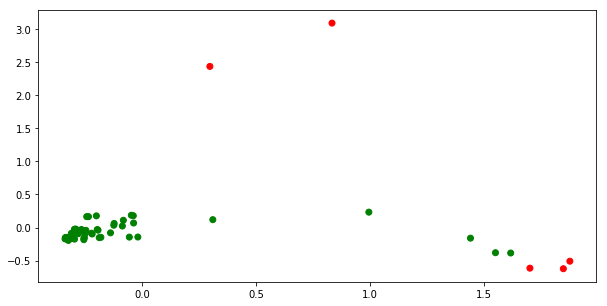

In [13]:
plot_anomaly(new_data)

### Interpretation

The result is similar to classic models. [index 47, 60, 61] matches with classic model

In addition, the unique row [index 16, 59] being picked up are 'Service Plan' item, which is a minority compared to 'Maintenance Budgeted Premium'